## Solution: Connected components and running time


### Implementing the breadth-first-search algorithm (BFS)

<font color='blue'><b>Task 1:</b></font> BFS can be implemented as follows:

In [1]:
def bfs(G, v1):
    # initialization
    import math
    nx.set_node_attributes(G, math.inf, "distance")
    G.nodes[v1]['distance'] = 0
    L = [v1]
    k = 1
    
    # main loop
    while L != []:
        Lnew = []
        for w in L:
            for v in G.neighbors(w):
                if G.nodes[v]['distance'] == math.inf:
                    G.nodes[v]['distance'] = k
                    Lnew = Lnew + [v]
        k = k + 1
        L = Lnew
    
    # return
    return dict([(v, G.nodes[v]['distance']) for v in G.nodes])

The above implementation will pass the checks on random graphs below.

{0: 0, 1: 3, 2: 2, 3: 3, 4: 1, 5: 3, 6: 2}


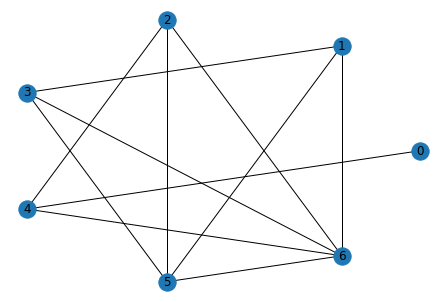

In [2]:
import networkx as nx
%matplotlib inline

# random graph G
G = nx.gnp_random_graph(7, 0.4)

# draw G
node_pos =  nx.circular_layout(G)
nx.draw(G, with_labels = True, pos = node_pos)

# calculate and print distances from vertex 0
dist = bfs(G,0)
print(dist)

---

### Measuring execution time

<font color='blue'><b>Task 2:</b></font> A typical plot might look as follows:

![](06_measuringRunningTime_bfs.png)

Note that in doubly logarithmic plots, a straight line corresponds to a polynomial function, with the slope indicating the exponent of the polynomial. It is clearly visible that the reference line and the data have a very similar slope (particularly for later measurements), thus the plot clearly supports the hypothesis that our BFS implementation has linear running time.

---

### Counting connected components

<font color='blue'><b>Task 3:</b></font> The vertices contained in the same connected component as a given vertex $s$ are precisely those with finite distance from $s$. Thus, the implementation is immediate from BFS:

In [3]:
import networkx as nx

def find_cc(G, s):
    
    import math
    
    dist = bfs(G,s)
    connected_to_s = [v for v in G.nodes if dist[v] < math.inf]
    
    return list(connected_to_s)

This implementation will pass the checks on random graphs below.

[0, 1, 2, 3, 4, 5, 6]


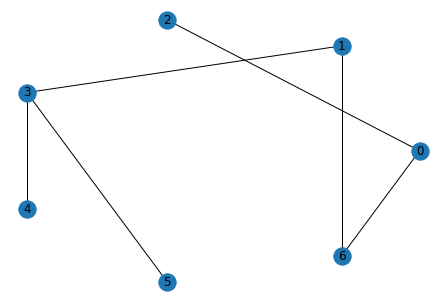

In [4]:
import networkx as nx
%matplotlib inline

# random graph G
G = nx.gnp_random_graph(7, 0.25)

# draw G
node_pos =  nx.circular_layout(G)
nx.draw(G, with_labels = True, pos = node_pos)

# calculate and print the component of vertex 0
comp = find_cc(G,0)
print(comp)

For completeness (to make this notebook run independently), we also copy the definition of `count_cc` here.

In [5]:
# A function for counting the number of connected components
def count_cc(G):
    
    num_cc = 0             # counter for the number of connected components
    nodes_found = []       # stores the vertices in connected components that were explored already
    vertices = nx.nodes(G) # shorthand for nx.nodes(G)
    
    for v in vertices:     # loop through vertices
        # if the component of v was not explored previously, do so now
        if v not in nodes_found: 
            new_nodes = find_cc(G,v)
            nodes_found = nodes_found + new_nodes
            num_cc += 1 
    
    return num_cc

---

<font color='blue'><b>Task 4:</b></font> The running time of the function `count_cc` is $O(|V|(|V|+|E|))$, i.e., quadratic in the input size. Indeed, one can see that the running time of the given implementation is dominated by the `for` loop, which is called at most once for every vertex (hence one factor $|V|$ in the running time bound); inside the loop, the `find_cc` function is called once, which incurs running time $O(|V|+|E|)$ in every call. This gives a total of $O(|V|(|V|+|E|))$.

Measuring execution times of `count_cc` on random graphs with the given parameters is done in the subsequent code cell.

In [6]:
import math
import time
import networkx as nx

# number of vertices for the random graphs
nn = [math.floor(math.pow(10,0.5*i)) for i in range(2,8)]
sizes = [] # list for storing graph sizes |V|+|E| 
times = [] # list for storing measured execution times

for n in nn:
    # generate random graph
    G = nx.gnp_random_graph(n, 0.1*math.log(n)/n)
    # store size
    sizes = sizes + [G.number_of_nodes() + G.number_of_edges()]
    # measure execution time of count_cc
    start_time = time.time()
    comp = count_cc(G)
    end_time = time.time()
    # store time
    times = times + [end_time - start_time]

The results are plotted by the next cell. Note that we also include a reference for quadratic growth in this plot.

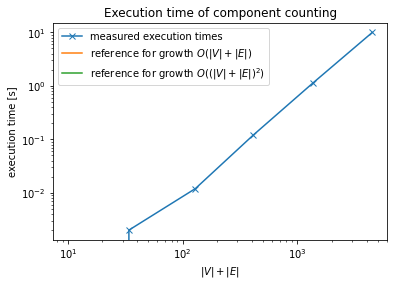

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot measured data
plt.plot(sizes, times, 'x-', 
         label = 'measured execution times')
# plot references for linear and quadratic growth
#   (scaled to be aligned with data at first measurment)
plt.plot(sizes, [s*times[0]/sizes[0] for s in sizes], '-', 
         label = 'reference for growth $O(|V|+|E|)$')
plt.plot(sizes, [math.pow(s,2)*times[0]/math.pow(sizes[0],2) for s in sizes], '-', 
         label = 'reference for growth $O((|V|+|E|)^2)$')
# logarithmic scale for axes
plt.xscale('log')
plt.yscale('log')
# title, axis labels, legend placement
plt.title('Execution time of component counting')
plt.xlabel('$|V|+|E|$')
plt.ylabel('execution time [s]')
plt.legend(loc = 'best')
# display plot
plt.show()

A typical plot resulting from the above might look as follows.

![](06_measuringRunningTime_countCC.png)

Although the growth might look subquadratic in the beginning, the last three measurements clearly indicate quadratic growth (recall that the slope is proportional to the exponent of the polynomial in doubly logarithmic plots, and observe that slope of the data curve and the one of the reference for quadratic growth are somewhat aligned for later measurements).

---

<font color='blue'><b>Task 5:</b></font> As indicated in the exercise statement, the initialization step of BFS (where distances are set to $\infty$) and the repeated checks whether a vertex is in the list of vertices explored already is what leads to quadratic running time. Both can be avoided by a careful reimplementation that reuses the distances in every BFS call. Check the following implementation for details.

In [8]:
def count_cc_fast(G):
    
    # counter for the number of connected components
    num_cc = 0 
    
    # set all distances to infinity
    nx.set_node_attributes(G, math.inf, 'distance')
    
    #-----------------------------------------------------#
    # helper function for BFS on graph with distances 
    #   already initialized (note: no return, as distances
    #   are modified in place)
    def bfs(G,v1):
        G.nodes[v1]['distance'] = 0
        L = [v1]
        k = 1

        # main loop
        while L != []:
            Lnew = []
            for w in L:
                for v in G.neighbors(w):
                    if G.nodes[v]['distance'] == math.inf:
                        G.nodes[v]['distance'] = k
                        Lnew = Lnew + [v]
            k = k + 1
            L = Lnew
        return
    #-----------------------------------------------------#
    
    # loop through vertices
    for v in G.nodes: 
        # if v was not explored previously, do so now
        if G.nodes[v]['distance'] == math.inf:
            bfs(G,v)
            num_cc += 1 
    
    return num_cc

Note how in the above code, we reuse the distances set globally, and how checking whether a vertex has been explored earlier is replaced by the more efficient checking of its distance.

For double-checking the implementation on a few examples, we can once again look at small random graphs:

3


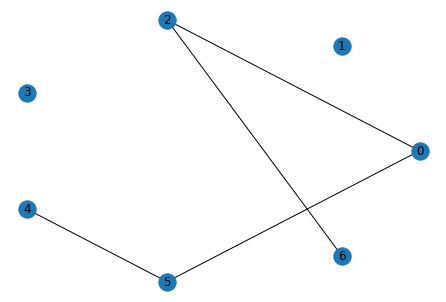

In [9]:
import networkx as nx
%matplotlib inline

# random graph G
G = nx.gnp_random_graph(7, 0.25)

# draw G
vx_pos =  nx.circular_layout(G)
nx.draw(G, with_labels = True, pos = vx_pos)

# count components and print result
comp = count_cc_fast(G)
print(comp)

To compare running times of our two implementations, we run a similar experiment as earlier, namely on random graphs with $n$ vertices and edge probability $p=\frac{\log n}{10n}$. Note that it is important to redo calculations for the first implementation, as well, to get comparable results on the same instances.

In [10]:
import math
import time
import networkx as nx

# number of vertices for the random graphs
nn = [math.floor(math.pow(10,0.5*i)) for i in range(2,8)]
sizes = [] # list for storing graph sizes |V|+|E| 
times = [] # list for storing measured execution times (count_cc)
times_fast = [] # list for storing measured execution times (count_cc_fast)

for n in nn:
    # generate random graph
    G = nx.gnp_random_graph(n, 0.1*math.log(n)/n)
    # store size
    sizes = sizes + [G.number_of_nodes() + G.number_of_edges()]
    # measure execution time of count_cc
    start_time = time.time()
    count_cc(G)
    end_time = time.time()
    # measure execution time of count_cc_fast
    start_time_fast = time.time()
    count_cc_fast(G)
    end_time_fast = time.time()
    # store times
    times = times + [end_time - start_time]
    times_fast = times_fast + [end_time_fast - start_time_fast]

Plotting follows the code seen earlier:

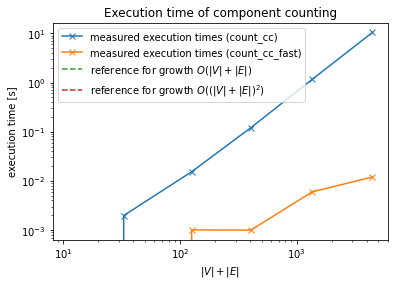

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot measured data
plt.plot(sizes, times, 'x-', 
         label = "measured execution times (count_cc)")
plt.plot(sizes, times_fast, 'x-', 
         label = "measured execution times (count_cc_fast)")
# plot references for linear and quadratic growth
#   (scaled to be aligned with data at first measurment)
plt.plot(sizes, [s*times_fast[0]/sizes[0] for s in sizes], '--', 
         label = 'reference for growth $O(|V|+|E|)$')
plt.plot(sizes, [math.pow(s,2)*times[0]/math.pow(sizes[0],2) for s in sizes], '--', 
         label = 'reference for growth $O((|V|+|E|)^2)$')
# logarithmic scale for axes
plt.xscale('log')
plt.yscale('log')
# title, axis labels, legend placement
plt.title('Execution time of component counting')
plt.xlabel('$|V|+|E|$')
plt.ylabel('execution time [s]')
plt.legend(loc = 'best')
# display plot
plt.savefig('measuringRunningTime_comparison')
plt.show()

A typical plot might look like this:

![](06_measuringRunningTime_comparison.png)

One can clearly see that the execution times of the old implementation follow the reference for quadratic growth, while the the execution times of the new implementation follow the reference for linear growth, thus indicating that the issues with quadratic running time are resolved.